# DATA

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import sklearn
import os
import pickle
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy.stats import norm


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  
tf.random.set_seed(1234)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/THESIS/data/final_data.csv')
data.head()

,r,sigma,T,s0,k,t,asset,call,asset_greater_call,scaled_call,scaled_asset,tau,moneyness,d1,d2,delta,gamma,theta,vega,rho
0,0.05,0.05,0.1,10.0,10.0,0.0,10.000000,0.090978,True,0.009098,1.0,0.10,1.000000,0.324133,0.308322,0.627082,2.394010,-0.608243,1.197005,0.617984
1,0.05,0.05,0.1,10.0,10.0,1.0,9.977024,0.071240,True,0.007124,1.0,0.09,0.997702,0.154153,0.139153,0.561255,2.634254,-0.604191,1.179973,0.497558
2,0.05,0.05,0.1,10.0,10.0,2.0,9.979236,0.066344,True,0.006634,1.0,0.08,0.997924,0.142939,0.128797,0.556831,2.798086,-0.622830,1.114591,0.439232
3,0.05,0.05,0.1,10.0,10.0,3.0,10.085137,0.133263,True,0.013326,1.0,0.07,1.008514,0.912040,0.898811,0.819126,1.972797,-0.657203,0.702286,0.568942
4,0.05,0.05,0.1,10.0,10.0,4.0,9.964273,0.045868,True,0.004587,1.0,0.06,0.996427,-0.041160,-0.053407,0.483584,3.266261,-0.644005,0.972889,0.286362


In [ ]:
scaler = StandardScaler()
X = data[['r','sigma','tau','moneyness']]
y = data['scaled_call']
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1234)

# NEURAL NET MODEL

In [ ]:
pip install -q -U tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.0 MB/s 


In [ ]:
from keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.initializers import RandomUniform, GlorotUniform, HeUniform
from keras.models import model_from_json
from keras import backend as K
import tensorflow_addons as tfa
from tensorflow import GradientTape

In [ ]:
def create_model(activation, lr_0, batch_norm, dropout_rate, layer_number, neuron_number,\
                neuron_decrease, data_length, initializer):
    opt = Adam(learning_rate = lr_0)
    model = Sequential()
    model.add(Dense(neuron_number, input_shape=(4,), activation = activation, \
                    kernel_initializer=initializer , bias_initializer=initializer))
    for i in range(layer_number):
        if batch_norm == True:
            model.add(BatchNormalization())         
        neuron_number = int(neuron_number/neuron_decrease)
        model.add(Dense(neuron_number, activation = activation))
    if batch_norm == True:
        model.add(BatchNormalization()) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, name='Final_1D_output', activation = activation))
    model.compile(optimizer=opt,loss='mean_squared_error',\
                  metrics=[tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))],\
                 run_eagerly=True)
    print(model.summary())
    return model

def callback_list(patience):
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    return early_stop

def plot_loss(loss,val_loss):    
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

def plot_metr(metr,val_metr,name):
    plt.figure()
    plt.plot(metr)
    plt.plot(val_metr)
    plt.title('Model'+str(name))
    plt.ylabel(str(name))
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show() 

In [ ]:
patience_f = 2
callbacks = callback_list(patience=patience_f)

# HYPERPARAMETER TUNED MODEL

## Result from RandomSearch

In [ ]:
# load json and create model
json_file_hyper = open('/content/drive/MyDrive/THESIS/results_search/model_r.json', 'r')
model_hyper = json_file_hyper.read()
json_file_hyper.close()
final_model = model_from_json(model_hyper)
# load weights into new model
final_model.load_weights("/content/drive/MyDrive/THESIS/results_search/model_r.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
final_hist = pd.read_csv('/content/drive/MyDrive/THESIS/results_search/train_hist_r.csv')
final_hist

,loss,r_square,val_loss,val_r_square
0,0.151701,0.481783,0.004211,0.985863
1,0.001003,0.996575,0.000228,0.999234
2,0.000146,0.999500,0.000102,0.999658
3,0.000078,0.999733,0.000061,0.999794
4,0.000049,0.999834,0.000039,0.999868
5,0.000032,0.999890,0.000027,0.999911
6,0.000022,0.999925,0.000019,0.999938
7,0.000016,0.999946,0.000013,0.999955
8,0.000012,0.999960,0.000010,0.999966
9,0.000009,0.999969,0.000008,0.999972


In [ ]:
# HYPERPARAMETER TUNING
a_file = open("/content/drive/MyDrive/THESIS/results_search/search_params_r.pkl", "rb")
output = pickle.load(a_file)
print(output)
a_file.close()

{'neuron_number': 256, 'neuron_decrease': 2, 'lr_0': 1e-05, 'layer_number': 3, 'initializer': <keras.initializers.initializers_v2.RandomUniform object at 0x7fe5c3066290>, 'dropout_rate': 0.0, 'data_length': 1000000, 'batch_size': 512, 'batch_norm': False, 'activation': 'relu'}


In [ ]:
final_model_arch = create_model(activation = output['activation'], lr_0 = output['lr_0'], \
                                 batch_norm = output['batch_norm'], dropout_rate = output['dropout_rate'], \
                                 layer_number = output['layer_number'], neuron_number = output['neuron_number'], \
                                    data_length = output['data_length'], neuron_decrease = output['neuron_decrease'],\
                                 initializer = output['initializer'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               1280      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 Final_1D_output (Dense)     (None, 1)                 33        
                                                                 
Total params: 44,545
Trainable params: 44,545
Non-traina

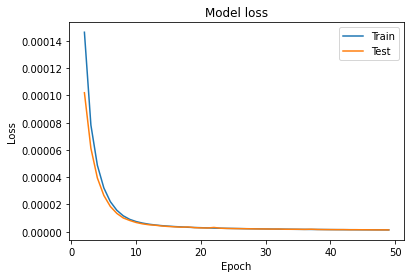

In [ ]:
plot_loss(final_hist['loss'][2:], final_hist['val_loss'][2:])

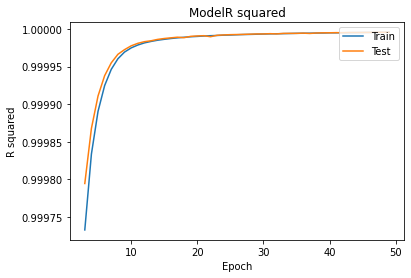

In [ ]:
plot_metr(final_hist['r_square'][3:], \
          final_hist['val_r_square'][3:], 'R squared')

# Extra fine-tuning

In [ ]:
sklearn_model = KerasRegressor(build_fn = create_model)

params = dict(activation=[output['activation']],lr_0 = [output['lr_0']], batch_norm=[True, False], \
              dropout_rate = [0.0,0.1], layer_number = [output['layer_number']],\
              neuron_decrease = [output['neuron_decrease']], neuron_number = [output['neuron_number']], \
              data_length = [output['data_length']], batch_size = [output['batch_size']], \
              initializer = [output['initializer']] )

len(ParameterGrid(params))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


4

In [ ]:
grid_search = GridSearchCV(sklearn_model, param_grid=params, cv=10, verbose=3) 

In [ ]:
start = datetime.now()
grid_search_results = grid_search.fit(X_train,y_train,callbacks=[callbacks],validation_split=0.2,\
                                         epochs = 50)
end = datetime.now()
total_time = (end-start).total_seconds()

# serialize model to JSON
model_json_test = grid_search_results.best_estimator_.model.to_json()
with open("/content/drive/MyDrive/THESIS/results_search/model_extra.json", "w") as json_file:
    json_file.write(model_json_test)
# serialize weights to HDF5
grid_search_results.best_estimator_.model.save_weights("/content/drive/MyDrive/THESIS/results_search/model_extra.h5")
print("Saved model to disk")


search_params_test = grid_search_results.best_params_

a_file_test = open("/content/drive/MyDrive/THESIS/results_search/search_params_extra.pkl", "wb")
pickle.dump(search_params_test, a_file_test)
a_file_test.close()
print("Saved parameters to disk")


model_hist_test = grid_search_results.best_estimator_.model.history
train_hist_test = pd.DataFrame(model_hist_test.history)
train_hist_test.to_csv('/content/drive/MyDrive/THESIS/results_search/train_hist_extra.csv', index=False)
print("Saved history to disk")
print(total_time)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               1280      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                           